# **IMPORTATION DES DONNÉES ET BIBLIOTHÈQUES 🌐**

- Dans un premier temps, on importe les bibliothèques nécessaires.
- Ensuite, on charge le jeu de données.
- on affiche le contenue du dataframe

In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')


import pickle
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold,train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dataset = pd.read_csv('fishing-train (1).csv')

In [3]:
dataset.head(5)

,url,label
0,http://mylust.com/videos/198456/svelte-nympho-...,legit
1,http://serverfault.com/questions/676825/basic-...,legit
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing


# **Nettoyage des données 🧹**
- On affiche les valeurs manquantes sur un graphique seaborn dédié pour mieux percevoir le poids de ces valeurs manquantes par rapport au dataset.
- Puis, après visualisation, la suppression de ces valeurs manquantes s'avère être la meilleure solution car elles ne sont pas assez représentatives et on le stocke dans un nouveau dataframe ( data_propre )
- Puis on a remarqué qu'il y'a d'autres modalités autre que legit et fishing dans le dataframe dataset , du coup après avoir remarqué qu'ils ne sont pas réprésentatifs on les a supprimé dans le data_propre


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23523 entries, 0 to 23522
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     23523 non-null  object
 1   label   23344 non-null  object
dtypes: object(2)
memory usage: 367.7+ KB


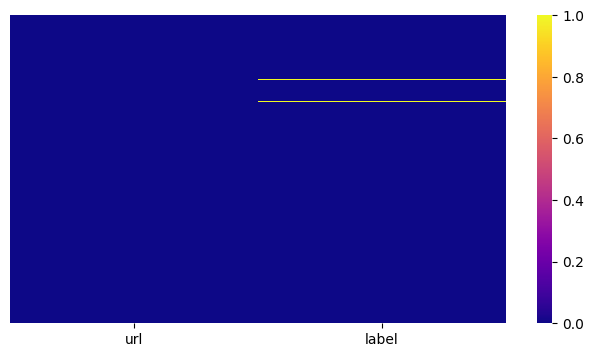

url        0
label    179
dtype: int64


In [5]:
plt.figure(figsize = (8,4))
sns.heatmap(dataset.isnull(), yticklabels = False, cbar = True, cmap = 'plasma')
plt.show()
print(dataset.isnull().sum())

In [6]:
dataset_propre = dataset.dropna(axis=0)

dataset_propre.isnull().sum()

url      0
label    0
dtype: int64

In [7]:
dataset_propre['label'].value_counts()

legit                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    17686
fishing                                                                                                                                                                                                                                                                                                                                                                                                  

In [8]:
dataset_propre = dataset_propre[(dataset_propre["label"] == "legit") | (dataset_propre["label"] == "fishing")]
dataset_propre['label'].value_counts()

legit      17686
fishing     5650
Name: label, dtype: int64

# **Création des features appropriés 🔑**
dans mon analyse je prévois crée les features :

- url tokenizer : tokenisation et une application de regex sur la la variable url
- url stemmer : applique le stemming vu qu'on a pas besoin de prendre en compte le contexte
- url_text : on transforme l'url stemmer en texte
- url_text_no_stopw : url_text sans stopword
- label_bin : pour encoder mes labels 0 pour legit et 1 pour fishing

In [15]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [16]:
dataset_propre['url_tokenizer'] = dataset_propre.url.map(lambda url: tokenizer.tokenize(url))

In [17]:
dataset_propre.head()

,url,label,url_tokenizer
0,http://mylust.com/videos/198456/svelte-nympho-...,legit,"[http, mylust, com, videos, svelte, nympho, ri..."
1,http://serverfault.com/questions/676825/basic-...,legit,"[http, serverfault, com, questions, basic, ncs..."
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit,"[http, otomoto, pl, osobowe, bmw, seria, e, sp..."
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit,"[http, motthegioi, vn, khoa, hoc, giao, duc, d..."
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing,"[https, att, yahoo, mail, weeblysite, com]"


In [18]:
stemmer = SnowballStemmer("english")
dataset_propre['url_stemmer'] = dataset_propre['url_tokenizer'].map(lambda i: [stemmer.stem(word) for word in i])
dataset_propre.head()

,url,label,url_tokenizer,url_stemmer
0,http://mylust.com/videos/198456/svelte-nympho-...,legit,"[http, mylust, com, videos, svelte, nympho, ri...","[http, mylust, com, video, svelt, nympho, ride..."
1,http://serverfault.com/questions/676825/basic-...,legit,"[http, serverfault, com, questions, basic, ncs...","[http, serverfault, com, question, basic, ncsa..."
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit,"[http, otomoto, pl, osobowe, bmw, seria, e, sp...","[http, otomoto, pl, osobow, bmw, seria, e, spo..."
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit,"[http, motthegioi, vn, khoa, hoc, giao, duc, d...","[http, motthegioi, vn, khoa, hoc, giao, duc, d..."
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing,"[https, att, yahoo, mail, weeblysite, com]","[https, att, yahoo, mail, weeblysit, com]"


In [19]:
dataset_propre['text'] = dataset_propre['url_stemmer'].map(lambda l: ' '.join(l))
dataset_propre.head()

,url,label,url_tokenizer,url_stemmer,text
0,http://mylust.com/videos/198456/svelte-nympho-...,legit,"[http, mylust, com, videos, svelte, nympho, ri...","[http, mylust, com, video, svelt, nympho, ride...",http mylust com video svelt nympho ride her lo...
1,http://serverfault.com/questions/676825/basic-...,legit,"[http, serverfault, com, questions, basic, ncs...","[http, serverfault, com, question, basic, ncsa...",http serverfault com question basic ncsa authe...
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit,"[http, otomoto, pl, osobowe, bmw, seria, e, sp...","[http, otomoto, pl, osobow, bmw, seria, e, spo...",http otomoto pl osobow bmw seria e sportowi co...
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit,"[http, motthegioi, vn, khoa, hoc, giao, duc, d...","[http, motthegioi, vn, khoa, hoc, giao, duc, d...",http motthegioi vn khoa hoc giao duc du hoc nh...
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing,"[https, att, yahoo, mail, weeblysite, com]","[https, att, yahoo, mail, weeblysit, com]",https att yahoo mail weeblysit com


In [20]:
dataset_propre['label_bin'] = dataset_propre['label'].map({'legit': 0, 'fishing': 1})
dataset_propre.head()

,url,label,url_tokenizer,url_stemmer,text,label_bin
0,http://mylust.com/videos/198456/svelte-nympho-...,legit,"[http, mylust, com, videos, svelte, nympho, ri...","[http, mylust, com, video, svelt, nympho, ride...",http mylust com video svelt nympho ride her lo...,0
1,http://serverfault.com/questions/676825/basic-...,legit,"[http, serverfault, com, questions, basic, ncs...","[http, serverfault, com, question, basic, ncsa...",http serverfault com question basic ncsa authe...,0
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit,"[http, otomoto, pl, osobowe, bmw, seria, e, sp...","[http, otomoto, pl, osobow, bmw, seria, e, spo...",http otomoto pl osobow bmw seria e sportowi co...,0
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit,"[http, motthegioi, vn, khoa, hoc, giao, duc, d...","[http, motthegioi, vn, khoa, hoc, giao, duc, d...",http motthegioi vn khoa hoc giao duc du hoc nh...,0
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing,"[https, att, yahoo, mail, weeblysite, com]","[https, att, yahoo, mail, weeblysit, com]",https att yahoo mail weeblysit com,1


# **Détection des stopwords**

- Nous allons retirer les stopwords communs.
- Nous allons retirer les stopwords de la langue également.
- Les mots qui sont inférieurs à 3 caractères seront également considérés comme des stopwords (cette décision est basée sur l'observation du jeu de données).
- Ensuite, nous allons créer une nouvelle caractéristique url_text_no_stopw qui correspond à la caractéristique text sans les stopwords définis.

In [21]:
# avec les stopwords
fishing_url= dataset_propre["text"][dataset_propre.label == 'fishing']
legitim_url = dataset_propre["text"][dataset_propre.label == 'legit']


In [22]:
# sans les stopwords
stopwords = set(STOPWORDS)
more_stopwords = {'com','http','html','https'}
stopwords_set = stopwords.union(more_stopwords)

def remove_stopwords(text):
    words = word_tokenize(text)
    cleaned_words = [word.lower() for word in words if word.lower() not in stopwords_set and len(word) > 3 ]
    return ' '.join(cleaned_words)

fishing_url_not_stop_word = fishing_url.apply(remove_stopwords)
legitim_url_not_stop_word = legitim_url.apply(remove_stopwords)

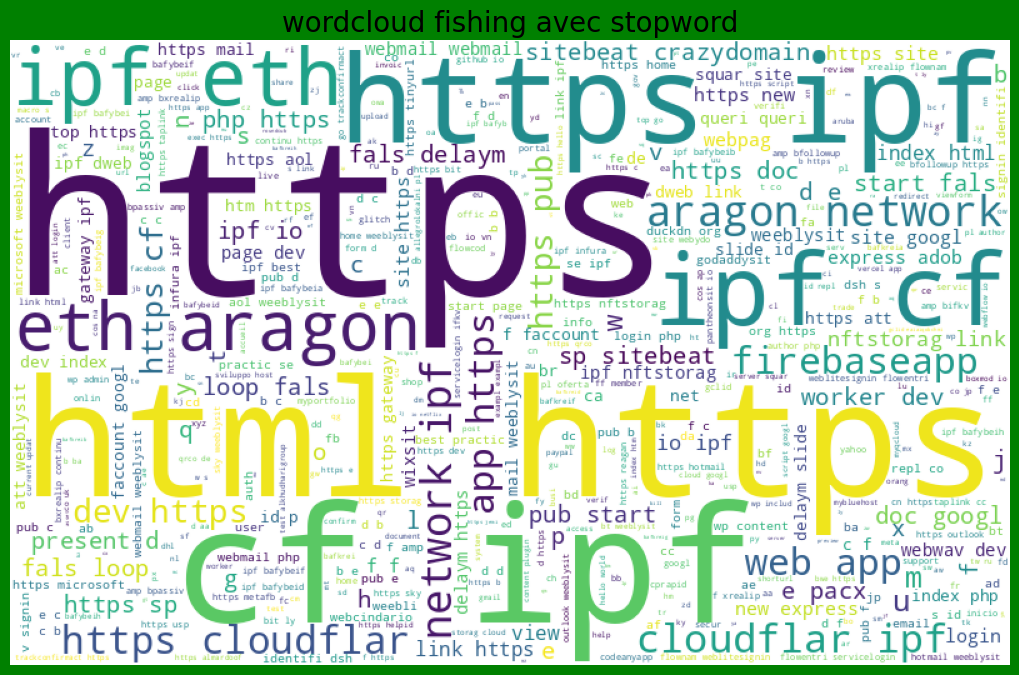

In [23]:
wordcloud = WordCloud(
        width=800,height=500,background_color='white',max_words = 500,
        ).generate(' '.join(fishing_url))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(wordcloud)
plt.title("wordcloud fishing avec stopword",fontsize=20);

plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


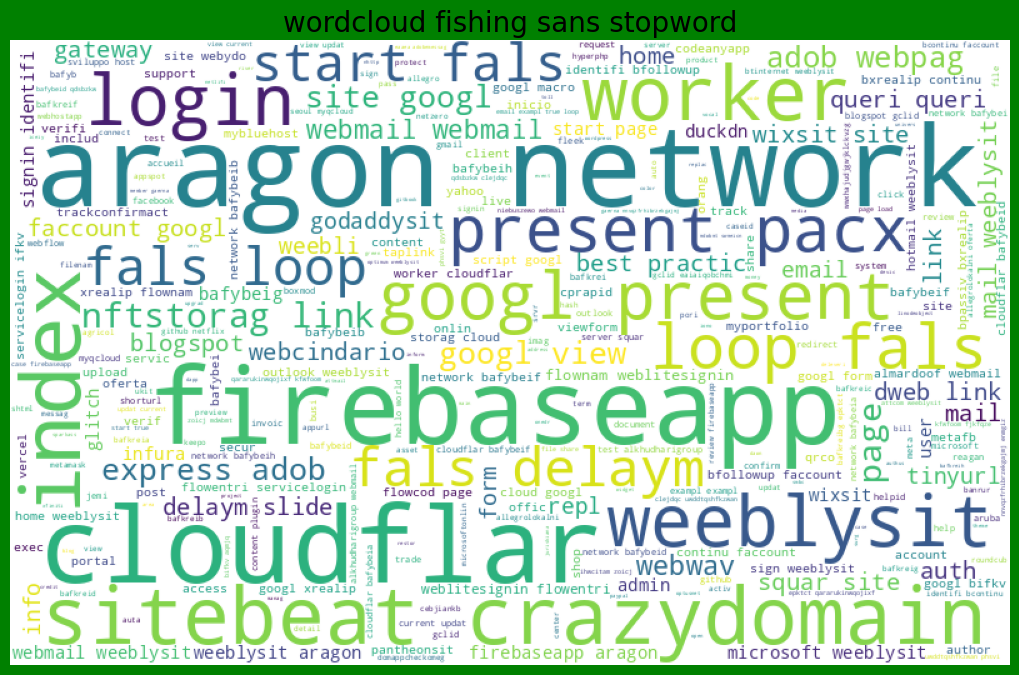

In [25]:
#wordcloud fishing sans stopword
wordcloud1 = WordCloud(
        width=800,height=500,background_color='white',max_words = 500,
        ).generate(' '.join(fishing_url_not_stop_word))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(wordcloud1)
plt.title("wordcloud fishing sans stopword",fontsize=20);

plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

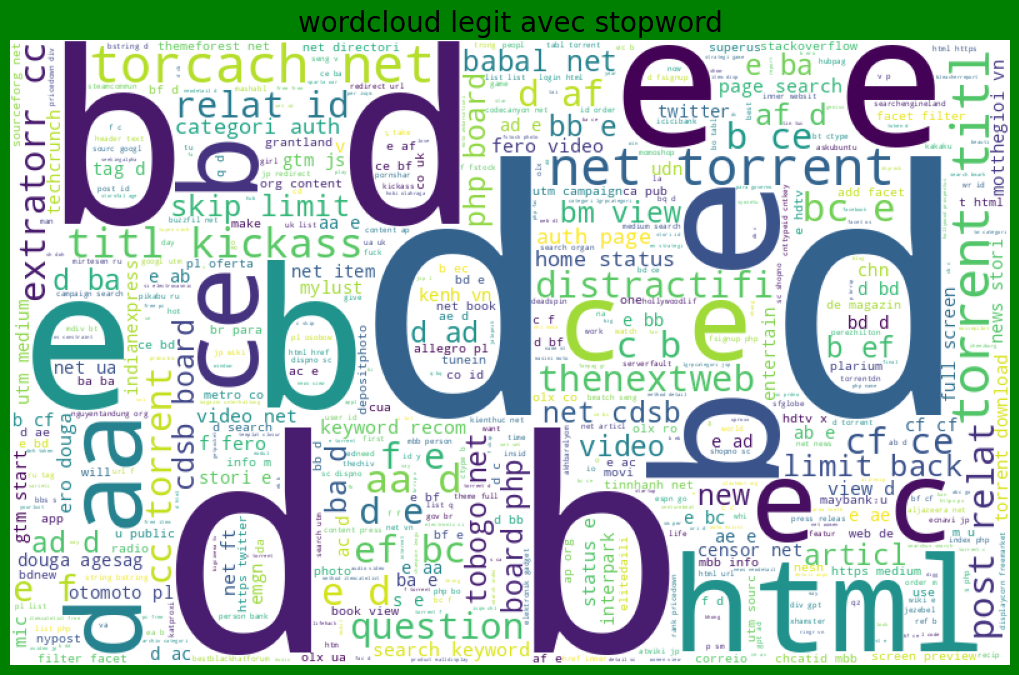

In [26]:
#wordcloud legit avec stopword
wordcloud1 = WordCloud(
        width=800,height=500,background_color='white',max_words = 500,
        ).generate(' '.join(legitim_url))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(wordcloud1)
plt.title("wordcloud legit avec stopword",fontsize=20);

plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


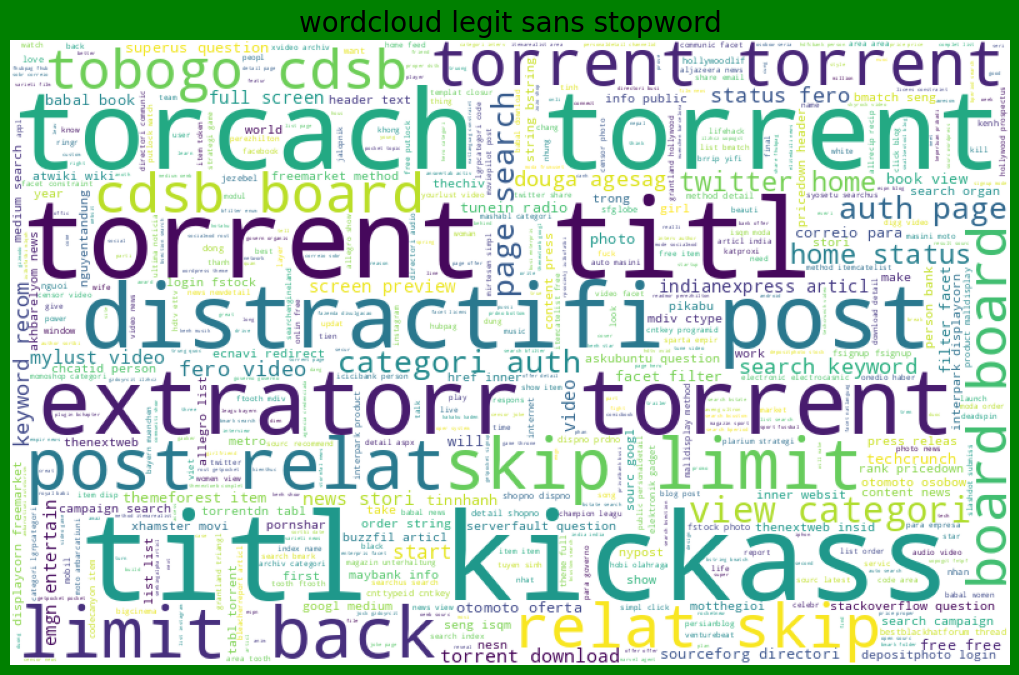

In [27]:
#wordcloud legit sans stopword
wordcloud1 = WordCloud(
        width=800,height=500,background_color='white',max_words = 500,
        ).generate(' '.join(legitim_url_not_stop_word))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(wordcloud1)
plt.title("wordcloud legit sans stopword",fontsize=20);

plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [28]:
dataset_propre['url_text_no_stopw'] = dataset_propre['text'].map(remove_stopwords)

In [29]:
dataset_propre

,url,label,url_tokenizer,url_stemmer,text,label_bin,url_text_no_stopw
0,http://mylust.com/videos/198456/svelte-nympho-...,legit,"[http, mylust, com, videos, svelte, nympho, ri...","[http, mylust, com, video, svelt, nympho, ride...",http mylust com video svelt nympho ride her lo...,0,mylust video svelt nympho ride lover prick fav...
1,http://serverfault.com/questions/676825/basic-...,legit,"[http, serverfault, com, questions, basic, ncs...","[http, serverfault, com, question, basic, ncsa...",http serverfault com question basic ncsa authe...,0,serverfault question basic ncsa authent workl ...
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit,"[http, otomoto, pl, osobowe, bmw, seria, e, sp...","[http, otomoto, pl, osobow, bmw, seria, e, spo...",http otomoto pl osobow bmw seria e sportowi co...,0,otomoto osobow seria sportowi coup rpsocimkj i...
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit,"[http, motthegioi, vn, khoa, hoc, giao, duc, d...","[http, motthegioi, vn, khoa, hoc, giao, duc, d...",http motthegioi vn khoa hoc giao duc du hoc nh...,0,motthegioi khoa giao nhung dieu hieu truoc
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing,"[https, att, yahoo, mail, weeblysite, com]","[https, att, yahoo, mail, weeblysit, com]",https att yahoo mail weeblysit com,1,yahoo mail weeblysit
...,...,...,...,...,...,...,...
23518,http://buzzfil.net/article/5285/c-mignon/ce-ch...,legit,"[http, buzzfil, net, article, c, mignon, ce, c...","[http, buzzfil, net, articl, c, mignon, ce, ch...",http buzzfil net articl c mignon ce chat n arr...,0,buzzfil articl mignon chat arriv toujour remet...
23519,http://kenh14.vn/doi-song/trao-luu-luon-song-c...,legit,"[http, kenh, vn, doi, song, trao, luu, luon, s...","[http, kenh, vn, doi, song, trao, luu, luon, s...",http kenh vn doi song trao luu luon song ca vo...,0,kenh song trao luon song khien cong dong mang ...
23520,http://abcnews.go.com/US/wireStory/exterminato...,legit,"[http, abcnews, go, com, US, wireStory, exterm...","[http, abcnew, go, com, us, wirestori, extermi...",http abcnew go com us wirestori extermin convi...,0,abcnew wirestori extermin convict slay philade...
23521,http://thenextweb.com/apps/2015/05/07/massive-...,legit,"[http, thenextweb, com, apps, massive, flickr,...","[http, thenextweb, com, app, massiv, flickr, o...",http thenextweb com app massiv flickr overhaul...,0,thenextweb massiv flickr overhaul coordin sear...


# **VECTORISATION**

- Nous allons opter pour la vectorisation TF-IDF car nous souhaitons pondérer les mots en fonction de leur importance relative dans l'ensemble des documents

In [56]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset_propre['url_text_no_stopw'])

In [63]:
y = dataset_propre["label_bin"]

# **Rééquilibrage**

- On visualise enfin la distribution de "legit" et "phishing", et on remarque qu'elle est déséquilibrée.

- On divise le jeu de donnée en train et test en prenant le soin de conserver cette même distribution ( 75,25 ) dans le train et le test

- On le réequilibre le train grace au sur-échantillonnage avec SMOTE ( X_resampled, y_resampled ) pour passer de  ( 75,25 )  à  ( 65,35 )

Text(0, 0.5, 'Fréquence')

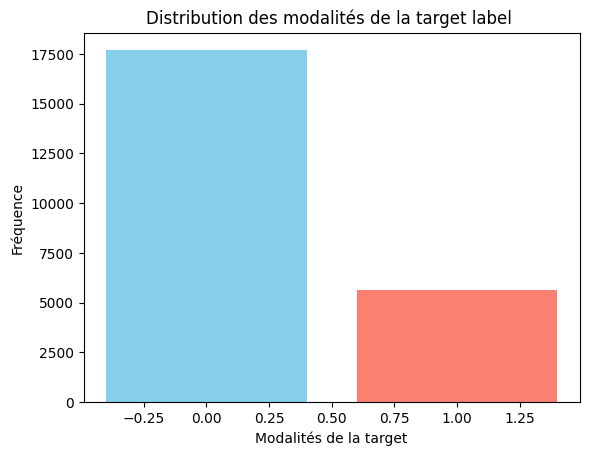

In [100]:
target_counts = y.value_counts()

# Création du diagramme à barres
plt.bar(target_counts.index, target_counts, color=['skyblue', 'salmon'])

# Ajout de titres et d'étiquettes
plt.title('Distribution des modalités de la target label ')
plt.xlabel('Modalités de la target')
plt.ylabel('Fréquence')


In [101]:
distribution_total = y.value_counts().sum()

distribution_legit = (dataset_propre[y==0]['label_bin'].count() / distribution_total )*100
distribution_fishing = (dataset_propre[y==1]['label_bin'].count() / distribution_total)*100

print(f"la distribution de legit est : {distribution_legit}")
print(f"la distribution de fishing est : {distribution_fishing}")

la distribution de legit est : 75.78848131642098
la distribution de fishing est : 24.21151868357902


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=dataset_propre["label_bin"])


Text(0, 0.5, 'Fréquence')

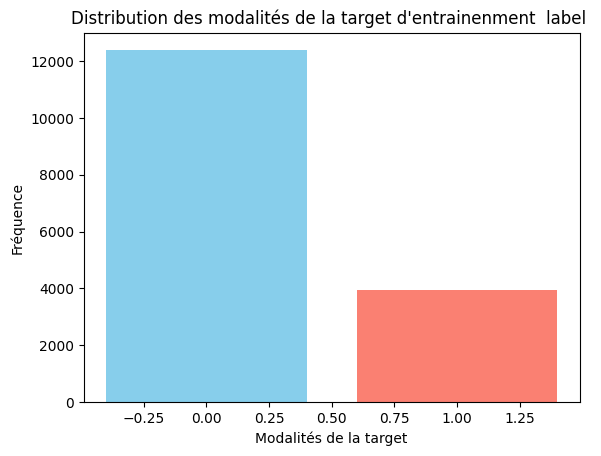

In [103]:
target_counts = y_train.value_counts()


plt.bar(target_counts.index, target_counts, color=['skyblue', 'salmon'])


plt.title("Distribution des modalités de la target d'entrainenment  label ")
plt.xlabel('Modalités de la target')
plt.ylabel('Fréquence')


In [104]:
proportion_initiale_positive = sum(y_train == 1) / len(y_train)
proportion_initiale_negative = sum(y_train == 0) / len(y_train)

proportion_cible_positive = 0.35
proportion_cible_negative = 0.65

rapport_smote = {
    0: int(len(y_train) * proportion_cible_negative / proportion_initiale_negative),
    1: int(len(y_train) * proportion_cible_positive / proportion_initiale_positive)
}
smote = SMOTE(sampling_strategy=rapport_smote, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (14009) in class 0 will be larger than the number of samples in the majority class (class #0 -> 12380)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (23613) in class 1 will be larger than the number of samples in the majority class (class #0 -> 12380)
  warnings.warn(


Text(0, 0.5, 'Fréquence')

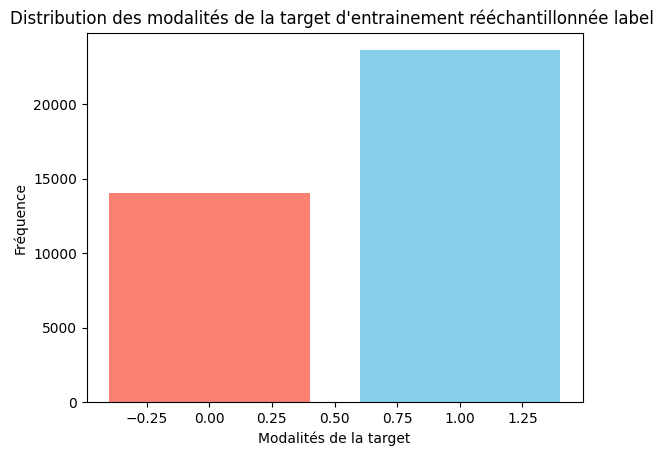

In [105]:
target_counts = y_resampled.value_counts()

# Création du diagramme à barres
plt.bar(target_counts.index, target_counts, color=['skyblue', 'salmon'])

# Ajout de titres et d'étiquettes
plt.title("Distribution des modalités de la target d'entrainement rééchantillonnée label ")
plt.xlabel('Modalités de la target')
plt.ylabel('Fréquence')


In [106]:
print("Proportion des classes après SMOTE :")
print(pd.Series(y_resampled).value_counts(normalize=True))

Proportion des classes après SMOTE :
1    0.627638
0    0.372362
Name: label_bin, dtype: float64


# **Implémentation des modèles et ajustement des hyperparamètres**

- On implémente 4 modèles :

  - **La regression logistique**
  - **Le random forest**
  - **Le Xgboost classifier**
  - **Le Multinomial Naive Bayes**

- On va tuner les hyperparamètres grâce à la fonction définies Best_parametre_models



In [107]:
def Best_parametre_models(X, y):

    a = int(np.sqrt(X.shape[1]))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    models = {
        'Regression logistic':LogisticRegression(),
        'Random Forest Classifier ':RandomForestClassifier(),
        'xgboost classifier':XGBClassifier(),
        'Multinomial Naive Bayes':MultinomialNB(),

        }

    params = {
        'Regression logistic' :{"C": [10,20,50,100,120,150]},
        'Random Forest Classifier ':{"n_estimators": [100,500]},
        'xgboost classifier':{"n_estimators": [80,100],"max_depth": [20,40]},
        'Multinomial Naive Bayes':  {"alpha": [0.000001,0.00001,0.0001,0.001,0.01,0.05,0.1, 0.5, 1.0],}
    }

    grid_results = pd.DataFrame()
    cv_results = pd.DataFrame(columns=['Model', 'Best Parameter', 'f1', 'Execution Time'])

    for model_name in models.keys():
        print(f"Processing {model_name}...")
        model = models[model_name]
        param_grid = params[model_name]


        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='f1')
        start_time = time()
        grid_search.fit(X, y)
        execution_time = time() - start_time


        for i in range(len(grid_search.cv_results_['params'])):
            row = {'Model': model_name}
            row.update(grid_search.cv_results_['params'][i])
            row['Score'] = grid_search.cv_results_['mean_test_score'][i]
            grid_results = grid_results.append(row, ignore_index=True)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        cv_results = cv_results.append({'Model': model_name, 'Best Parameter': best_params, 'f1': best_score, 'Execution Time': execution_time}, ignore_index=True)


    plt.figure(figsize=(16, 10))
    sns.violinplot(data=grid_results, x='Model', y='Score')
    plt.axvline(x=cv_results['f1'].idxmax(), color='red', linestyle='--')
    plt.title('Grid Search Scores')
    plt.show()
    return grid_results, cv_results


Processing Regression logistic...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Processing Random Forest Classifier ...


<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cv_results = cv_results.append({'Model': model_name, 'Best Parameter': best_params, 'f1': best_score, 'Execution Time': execution_time}, ignore_index=True)


Processing xgboost classifier...


<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:44: FutureWarning: The frame.append method 

Processing Multinomial Naive Bayes...


<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(row, ignore_index=True)
<ipython-input-107-3e1f6a52a4b3>:40: FutureWarning: The frame.append method 

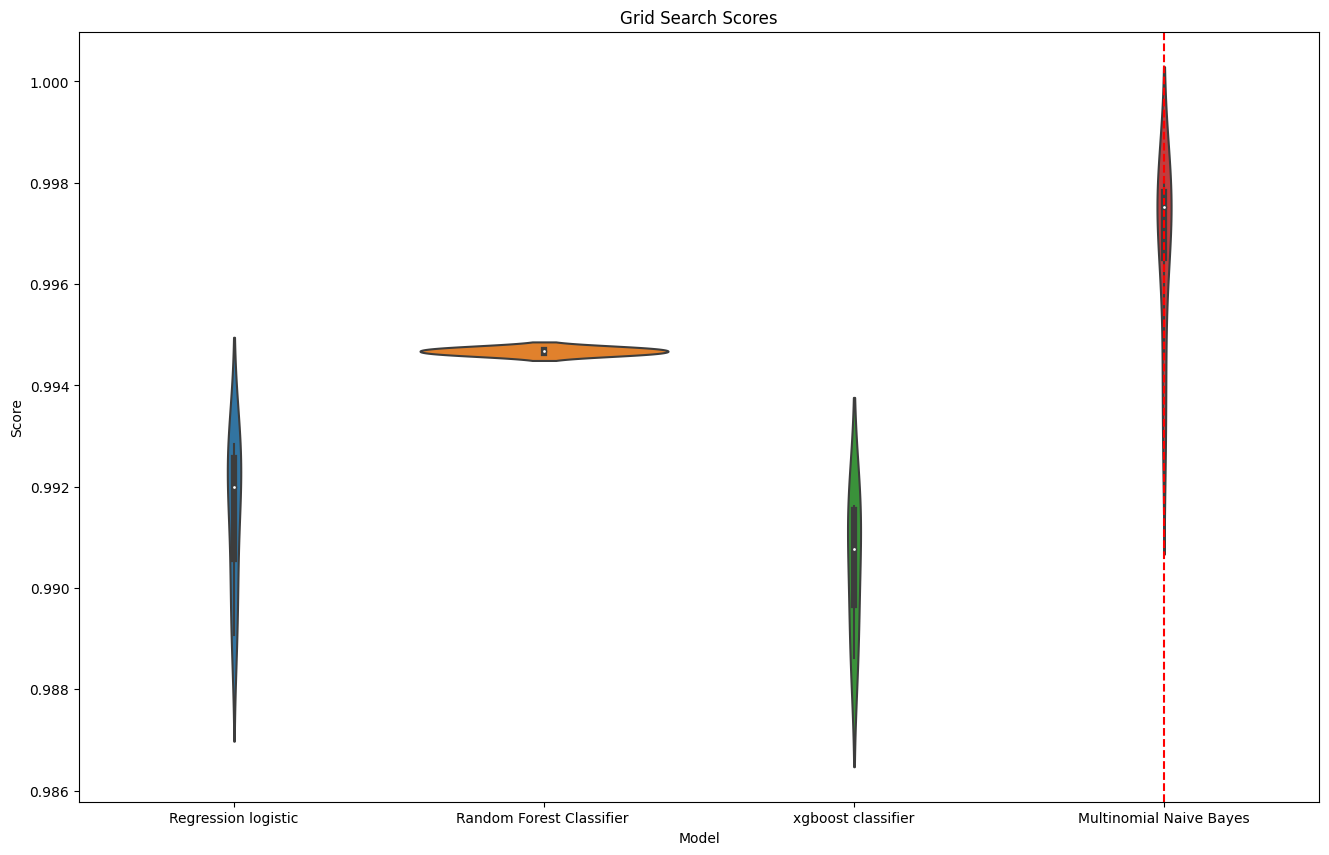

(                        Model      C     Score  n_estimators  max_depth  \
 0         Regression logistic   10.0  0.989081           NaN        NaN   
 1         Regression logistic   20.0  0.990223           NaN        NaN   
 2         Regression logistic   50.0  0.991595           NaN        NaN   
 3         Regression logistic  100.0  0.992389           NaN        NaN   
 4         Regression logistic  120.0  0.992618           NaN        NaN   
 5         Regression logistic  150.0  0.992847           NaN        NaN   
 6   Random Forest Classifier     NaN  0.994623         100.0        NaN   
 7   Random Forest Classifier     NaN  0.994729         500.0        NaN   
 8          xgboost classifier    NaN  0.988620          80.0       20.0   
 9          xgboost classifier    NaN  0.990012         100.0       20.0   
 10         xgboost classifier    NaN  0.991616          80.0       40.0   
 11         xgboost classifier    NaN  0.991510         100.0       40.0   
 12    Multi

In [108]:
Best_parametre_models(X_resampled, y_resampled)

# **ENTRAINEMENT DES ALGO AVEC LES BEST PARAMETRES**
- Regression logistic : ("C":150)
- Random Forest Classifier : ("n_estimators: 500")
- xgboost classifier : ("max_depth': 40, 'n_estimators: 80")
- Multinomial Naive Bayes :("alpha: 1e-06")

In [111]:
regression_logistic = LogisticRegression(C=150)
random_forest = RandomForestClassifier(n_estimators=500)
xgboost_classifier = XGBClassifier(n_estimators = 80 , max_depth = 40)
Multinomial_Naive_Bayes = MultinomialNB(alpha=0.000001)

In [112]:
regression_logistic.fit(X_resampled,y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=150)

In [113]:
random_forest.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=500)

In [114]:
xgboost_classifier.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [115]:
Multinomial_Naive_Bayes.fit(X_resampled, y_resampled)

MultinomialNB(alpha=1e-06)

#**ÉVALUATION DES MODÈLES**

In [116]:
def testeur_ehouman(X,y,model):
    test_predictions = model.predict(X)

    # Comparez les prédictions avec les vraies étiquettes
    accuracy = accuracy_score(y, test_predictions)
    precision = precision_score(y, test_predictions)
    recall = recall_score(y, test_predictions)
    f1 = f1_score(y, test_predictions)


    # Affichez les métriques de performance
    print(f"accuracy : {accuracy}")
    print(f"precision : {precision}")
    print(f"Rappel : {recall}")
    print(f"F1-score : {f1}")

In [117]:
testeur_ehouman(X_test,y_test,regression_logistic)

accuracy : 0.9924296529067276
precision : 0.9784382284382285
Rappel : 0.9905604719764012
F1-score : 0.9844620345939608


In [118]:
testeur_ehouman(X_test,y_test,random_forest)

accuracy : 0.9912869590058563
precision : 0.9722543352601156
Rappel : 0.9923303834808259
F1-score : 0.9821897810218978


In [119]:
testeur_ehouman(X_test,y_test,xgboost_classifier)

accuracy : 0.9810027138980145
precision : 0.935340022296544
Rappel : 0.9899705014749263
F1-score : 0.9618801948982516


In [120]:
testeur_ehouman(X_test,y_test,Multinomial_Naive_Bayes)

accuracy : 0.9831452649621483
precision : 0.998104864181933
Rappel : 0.9321533923303835
F1-score : 0.9640024405125077


**Les 4 modèles sont de très bon modèle**
mais on retiendra la regression logistique

In [121]:
data_test = pd.read_csv("phishing_site_urls.csv")
data_test

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
207543,libflaim.sourcearchive.com/documentation/4.9.9...,good
207544,libguides.lib.msu.edu/content.php?pid=62444&si...,good
207545,libguides.lib.msu.edu/content.php?pid=63292&si...,good
207546,libguides.lib.msu.edu/content.php?pid=63292&si...,good


In [122]:
data_test["label_encode"] = data_test["Label"].map({"bad":1 , "good":0})

In [123]:
data_test= data_test.dropna()

In [124]:
data_test['url_tokenizer'] = data_test.URL.map(lambda url: tokenizer.tokenize(url))

<ipython-input-124-06f4aa0512cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['url_tokenizer'] = data_test.URL.map(lambda url: tokenizer.tokenize(url))


In [125]:
data_test['url_stemmer'] = data_test['url_tokenizer'].map(lambda i: [stemmer.stem(word) for word in i])

<ipython-input-125-9b3da2b66f5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['url_stemmer'] = data_test['url_tokenizer'].map(lambda i: [stemmer.stem(word) for word in i])


In [126]:
data_test['text'] = data_test['url_stemmer'].map(lambda l: ' '.join(l))

<ipython-input-126-900e9e5834d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['text'] = data_test['url_stemmer'].map(lambda l: ' '.join(l))


In [127]:
data_test['url_text_no_stopw'] = data_test['text'].map(remove_stopwords)

<ipython-input-127-92e309d7865a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['url_text_no_stopw'] = data_test['text'].map(remove_stopwords)


In [128]:
data_test.head()

,URL,Label,label_encode,url_tokenizer,url_stemmer,text,url_text_no_stopw
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,1.0,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...,nobel login skype verif login index profil out...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,1.0,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...,dghjdgf paypal cycgi webscrcmd home custom load
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,1.0,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...,serviciosbi paypal herf secur dispatch href hr...
3,mail.printakid.com/www.online.americanexpress....,bad,1.0,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...,mail printakid onlin americanexpress index
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,1.0,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...,thewhiskeydreg content theme widescreen includ...


In [129]:
X1 = vectorizer.transform(data_test['url_text_no_stopw'])
Y1 = data_test["label_encode"]

In [134]:
testeur_ehouman(X1,Y1,regression_logistic)

accuracy : 0.624335692638294
precision : 0.544068161161182
Rappel : 0.8648410186277862
F1-score : 0.66793867120954


In [135]:
testeur_ehouman(X1,Y1,random_forest)

accuracy : 0.5822343854644972
precision : 0.5121542998326293
Rappel : 0.9213309657994287
F1-score : 0.6583445634442159


In [136]:
testeur_ehouman(X1,Y1,xgboost_classifier)

accuracy : 0.5043339580914202
precision : 0.46677919037377835
Rappel : 0.9455173098344565
F1-score : 0.6250072903301062


In [137]:
testeur_ehouman(X1,Y1,Multinomial_Naive_Bayes)

accuracy : 0.6523582610203954
precision : 0.5977142495330358
Rappel : 0.6246760265134387
F1-score : 0.6108977954182665


# **PREDICTION DU DATASET fishing-submission.csv**

In [140]:
data_submit = pd.read_csv("fishing-submission.csv")
data_submit

,id,url,label
0,30508,https://pub-54efd4aa11884bfb834031d41082f502.r...,NaN
1,1173,https://rectify-assets-dapps.firebaseapp.com/,NaN
2,2736,https://mynumbercardpoint-sounu-go.jp/,NaN
3,30901,https://bitly.ws/yVM8,NaN
4,19773,https://pub-4afae60814504773ac23cae60e99889a.r...,NaN
...,...,...,...
50749,8071,http://himado.in/?keyword=%E3%82%B5%E3%83%83%E...,NaN
50750,31032,https://cloudflare-ipfs.com/ipfs/bafybeigine6e...,NaN
50751,19948,http://torcache.net/torrent/CAEDFE4CAA2BAA2CAE...,NaN
50752,23191,https://bafybeig5b56cimh5zvkv64cjckamxgv32rlbd...,NaN


In [141]:
data_submit['url_tokenizer'] = data_submit.url.map(lambda url: tokenizer.tokenize(url))

In [142]:
data_submit['url_stemmer'] = data_submit['url_tokenizer'].map(lambda i: [stemmer.stem(word) for word in i])

In [143]:
data_submit['text'] = data_submit['url_stemmer'].map(lambda l: ' '.join(l))

In [144]:
data_submit['url_text_no_stopw'] = data_submit['text'].map(remove_stopwords)

In [147]:
data_submit

,id,url,label,url_tokenizer,url_stemmer,text,url_text_no_stopw
0,30508,https://pub-54efd4aa11884bfb834031d41082f502.r...,NaN,"[https, pub, efd, aa, bfb, d, f, r, dev, res, ...","[https, pub, efd, aa, bfb, d, f, r, dev, res, ...",https pub efd aa bfb d f r dev res html,
1,1173,https://rectify-assets-dapps.firebaseapp.com/,NaN,"[https, rectify, assets, dapps, firebaseapp, com]","[https, rectifi, asset, dapp, firebaseapp, com]",https rectifi asset dapp firebaseapp com,rectifi asset dapp firebaseapp
2,2736,https://mynumbercardpoint-sounu-go.jp/,NaN,"[https, mynumbercardpoint, sounu, go, jp]","[https, mynumbercardpoint, sounu, go, jp]",https mynumbercardpoint sounu go jp,mynumbercardpoint sounu
3,30901,https://bitly.ws/yVM8,NaN,"[https, bitly, ws, yVM]","[https, bit, ws, yvm]",https bit ws yvm,
4,19773,https://pub-4afae60814504773ac23cae60e99889a.r...,NaN,"[https, pub, afae, ac, cae, e, a, r, dev, a, h...","[https, pub, afa, ac, cae, e, a, r, dev, a, html]",https pub afa ac cae e a r dev a html,
...,...,...,...,...,...,...,...
50749,8071,http://himado.in/?keyword=%E3%82%B5%E3%83%83%E...,NaN,"[http, himado, in, keyword, E, B, E, E, AB, E,...","[http, himado, in, keyword, e, b, e, e, ab, e,...",http himado in keyword e b e e ab e bc d e a e...,himado keyword
50750,31032,https://cloudflare-ipfs.com/ipfs/bafybeigine6e...,NaN,"[https, cloudflare, ipfs, com, ipfs, bafybeigi...","[https, cloudflar, ipf, com, ipf, bafybeigin, ...",https cloudflar ipf com ipf bafybeigin ebw yfp...,cloudflar bafybeigin pbnrohetydsbognk ukfn sgfc
50751,19948,http://torcache.net/torrent/CAEDFE4CAA2BAA2CAE...,NaN,"[http, torcache, net, torrent, CAEDFE, CAA, BA...","[http, torcach, net, torrent, caedf, caa, baa,...",http torcach net torrent caedf caa baa cae f c...,torcach torrent caedf torrent titl kickass mag...
50752,23191,https://bafybeig5b56cimh5zvkv64cjckamxgv32rlbd...,NaN,"[https, bafybeig, b, cimh, zvkv, cjckamxgv, rl...","[https, bafybeig, b, cimh, zvkv, cjckamxgv, rl...",https bafybeig b cimh zvkv cjckamxgv rlbd kwda...,bafybeig cimh zvkv cjckamxgv rlbd kwdat tjuc z...


In [155]:
X_submit = vectorizer.transform(data_submit['url_text_no_stopw'])


In [159]:
def testeur_ehouman_submit(X,model,dataframe):
    test_predictions = model.predict(X)
    dataframe["prediction_label"] = test_predictions

In [161]:
testeur_ehouman_submit(X_submit,regression_logistic,data_submit)

In [162]:
test_predict = data_submit.prediction_label

In [165]:
datafr = pd.read_csv("fishing-submission.csv")
datafr["prediction_label"] = test_predict

In [168]:
datafr.to_csv("fishing-submission_ehouman.csv")

#**DUMP du meilleur modèle**

In [170]:
with open('Regression_logistic_model.pkl', 'wb') as file:
    pickle.dump(regression_logistic, file)
